## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0903 20:47:04.191862  4496 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 20:47:04.193433  4496 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 20:47:04.197448  4496 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 20:47:04.311771  4496 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3


W0903 20:47:04.593755  4496 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0903 20:47:04.617928  4496 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0903 20:47:04.714830  4496 deprecation.py:323] From C:\Users\sam0522\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 5s 95us/step - loss: 1.2456 - acc: 0.5677 - val_loss: 1.4629 - val_acc: 0.4859
Epoch 15/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2264 - acc: 0.5740 - val_loss: 1.4646 - val_acc: 0.4839
Epoch 16/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.2071 - acc: 0.5808 - val_loss: 1.4750 - val_acc: 0.4794
Epoch 17/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1886 - acc: 0.5885 - val_loss: 1.4635 - val_acc: 0.4799
Epoch 18/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.1695 - acc: 0.5955 - val_loss: 1.4601 - val_acc: 0.4822
Epoch 19/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1518 - acc: 0.6016 - val_loss: 1.4600 - val_acc: 0.4842
Epoch 20/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1350 - acc: 0.6075 - val_loss: 1.4468 - val_acc: 0.4958
Epoch 21/25
50000/50000 [=================

50000/50000 [==============================] - 6s 118us/step - loss: 2.2503 - acc: 0.2679 - val_loss: 2.2135 - val_acc: 0.2939
Epoch 2/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.7631 - acc: 0.3849 - val_loss: 1.8622 - val_acc: 0.3605
Epoch 3/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.6345 - acc: 0.4280 - val_loss: 1.7180 - val_acc: 0.3980
Epoch 4/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.5600 - acc: 0.4531 - val_loss: 1.6352 - val_acc: 0.4338
Epoch 5/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.5033 - acc: 0.4749 - val_loss: 1.6074 - val_acc: 0.4359
Epoch 6/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.4602 - acc: 0.4885 - val_loss: 1.5695 - val_acc: 0.4457
Epoch 7/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.4223 - acc: 0.5008 - val_loss: 1.5674 - val_acc: 0.4546
Epoch 8/25
50000/50000 [===========================

50000/50000 [==============================] - 5s 97us/step - loss: 1.2350 - acc: 0.5704 - val_loss: 1.4823 - val_acc: 0.4793
Epoch 25/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.2239 - acc: 0.5736 - val_loss: 1.4828 - val_acc: 0.4802
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.4049 - acc: 0.5101 - val_loss: 1.5486 - val_acc: 0.4560
Epoch 13/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.3845 - acc: 0.5169 - val_loss: 1.5382 - val_acc: 0.4600
Epoch 14/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.3659 - acc: 0.5233 - val_loss: 1.5261 - val_acc: 0.4627
Epoch 15/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.3506 - acc: 0.5285 - val_loss: 1.5199 - val_acc: 0.4667
Epoch 16/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.3330 - acc: 0.5354 - val_loss: 1.5122 - val_acc: 0.4651
Epoch 17/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.3177 - acc: 0.5415 - val_loss: 1.5048 - val_acc: 0.4706
Epoch 18/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.3032 - acc: 0.5464 - val_loss: 1.5009 - val_acc: 0.4706
Epoch 19/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 131us/step - loss: 2.3615 - acc: 0.2375 - val_loss: 2.2404 - val_acc: 0.2857
Epoch 2/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.8977 - acc: 0.3473 - val_loss: 1.9641 - val_acc: 0.3339
Epoch 3/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.7591 - acc: 0.3880 - val_loss: 1.8081 - val_acc: 0.3692
Epoch 4/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.6814 - acc: 0.4133 - val_loss: 1.7417 - val_acc: 0.3915
Epoch 5/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.6268 - acc: 0.4305 - val_loss: 1.6961 - val_acc: 0.4069
Epoch 6/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.5824 - acc: 0.4477 - val_loss: 1.6661 - val_acc: 0.4174
Epoch 7/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.5463 - acc: 0.4598 - val_loss: 1.6529 - val_ac

Epoch 22/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.4893 - acc: 0.8363 - val_loss: 2.0355 - val_acc: 0.4267

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 23/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.4704 - acc: 0.8414 - val_loss: 2.0721 - val_acc: 0.4519
Epoch 24/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.4133 - acc: 0.8656 - val_loss: 2.0640 - val_acc: 0.4468
Epoch 25/25
50000/50000 [==============================] - 5s 104us/step - loss: 0.3929 - acc: 0.8717 - val_loss: 2.1365 - val_acc: 0.4629

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________

50000/50000 [==============================] - 5s 104us/step - loss: 1.2894 - acc: 0.5408 - val_loss: 1.5921 - val_acc: 0.4357
Epoch 7/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.2366 - acc: 0.5598 - val_loss: 1.6626 - val_acc: 0.4293
Epoch 8/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1931 - acc: 0.5792 - val_loss: 1.6120 - val_acc: 0.4361
Epoch 9/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1549 - acc: 0.5890 - val_loss: 1.5686 - val_acc: 0.4715
Epoch 10/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1167 - acc: 0.6047 - val_loss: 1.4805 - val_acc: 0.4729
Epoch 11/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.0774 - acc: 0.6187 - val_loss: 1.5302 - val_acc: 0.4700
Epoch 12/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.0371 - acc: 0.6341 - val_loss: 1.5108 - val_acc: 0.4774
Epoch 13/25
50000/50000 [=================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_41 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_42 (Batc (None, 256)               1024      
__________

50000/50000 [==============================] - 5s 106us/step - loss: 1.2519 - acc: 0.5690 - val_loss: 1.4707 - val_acc: 0.4785
Epoch 14/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.2345 - acc: 0.5752 - val_loss: 1.4707 - val_acc: 0.4846
Epoch 15/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.2181 - acc: 0.5809 - val_loss: 1.4659 - val_acc: 0.4841
Epoch 16/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.2026 - acc: 0.5856 - val_loss: 1.4535 - val_acc: 0.4867
Epoch 17/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.1870 - acc: 0.5926 - val_loss: 1.4565 - val_acc: 0.4873
Epoch 18/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.1737 - acc: 0.5970 - val_loss: 1.4751 - val_acc: 0.4802
Epoch 19/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1616 - acc: 0.6031 - val_loss: 1.4433 - val_acc: 0.4906
Epoch 20/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.9898 - acc: 0.3263 - val_loss: 2.0170 - val_acc: 0.3302
Epoch 2/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.6392 - acc: 0.4273 - val_loss: 1.7118 - val_acc: 0.3996
Epoch 3/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.5426 - acc: 0.4599 - val_loss: 1.6422 - val_acc: 0.4233
Epoch 4/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4823 - acc: 0.4804 - val_loss: 1.6174 - val_acc: 0.4338
Epoch 5/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4362 - acc: 0.5007 - val_loss: 1.5892 - val_acc: 0.4463
Epoch 6/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.3999 - acc: 0.5141 - val_loss: 1.5746 - val_acc: 0.4392
Epoch 7/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.3677 - acc: 0.5247 - val_loss: 1.5398 - 

50000/50000 [==============================] - 5s 109us/step - loss: 1.6840 - acc: 0.4144 - val_loss: 1.7713 - val_acc: 0.3889
Epoch 24/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.6762 - acc: 0.4181 - val_loss: 1.7659 - val_acc: 0.3907
Epoch 25/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.6687 - acc: 0.4212 - val_loss: 1.7603 - val_acc: 0.3909
Numbers of exp: 18, reduce_factor: 0.99, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 5s 108us/step - loss: 1.1679 - acc: 0.5887 - val_loss: 1.8574 - val_acc: 0.3750
Epoch 8/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1228 - acc: 0.6044 - val_loss: 1.8990 - val_acc: 0.3654
Epoch 9/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.0789 - acc: 0.6211 - val_loss: 2.0324 - val_acc: 0.3959

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Epoch 10/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.0330 - acc: 0.6362 - val_loss: 1.6975 - val_acc: 0.4230
Epoch 11/25
50000/50000 [==============================] - 5s 108us/step - loss: 0.9971 - acc: 0.6499 - val_loss: 1.7649 - val_acc: 0.4234
Epoch 12/25
50000/50000 [==============================] - 5s 108us/step - loss: 0.9623 - acc: 0.6624 - val_loss: 1.8164 - val_acc: 0.4160
Epoch 13/25
50000/50000 [==============================] - 5s 109us/step - loss: 0.9245 - acc: 0.67

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.8288 - acc: 0.3702 - val_loss: 2.0913 - val_acc: 0.3099
Epoch 2/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.5328 - acc: 0.4589 - val_loss: 2.3934 - val_acc: 0.2796
Epoch 3/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.4181 - acc: 0.4990 - val_loss: 1.8870 - val_acc: 0.3522
Epoch 4/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.3433 - acc: 0.5240 - val_loss: 1.8915 - val_acc: 0.3533
Epoch 5/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2723 - acc: 0.5516 - val_loss: 1.9420 - val_acc: 0.3507
Epoch 6/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2171 - acc: 0.5723 - val_loss: 1.6511 - val_acc: 0.4240
Epoch 7/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.1580 - acc: 0.5916 - val_loss: 2.4840 - 

Epoch 21/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.2823 - acc: 0.5556 - val_loss: 1.5283 - val_acc: 0.4653
Epoch 22/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.2659 - acc: 0.5632 - val_loss: 1.5276 - val_acc: 0.4665
Epoch 23/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.2523 - acc: 0.5682 - val_loss: 1.5253 - val_acc: 0.4638
Epoch 24/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.2397 - acc: 0.5723 - val_loss: 1.5206 - val_acc: 0.4686
Epoch 25/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.2268 - acc: 0.5778 - val_loss: 1.5264 - val_acc: 0.4671
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)              0         
_______________________________________________

50000/50000 [==============================] - 6s 111us/step - loss: 1.5450 - acc: 0.4581 - val_loss: 1.6601 - val_acc: 0.4204
Epoch 9/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.5127 - acc: 0.4694 - val_loss: 1.6322 - val_acc: 0.4308
Epoch 10/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.4853 - acc: 0.4798 - val_loss: 1.6252 - val_acc: 0.4336
Epoch 11/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4596 - acc: 0.4889 - val_loss: 1.5987 - val_acc: 0.4448
Epoch 12/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4360 - acc: 0.4986 - val_loss: 1.5888 - val_acc: 0.4474
Epoch 13/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.4134 - acc: 0.5069 - val_loss: 1.5878 - val_acc: 0.4436
Epoch 14/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3944 - acc: 0.5135 - val_loss: 1.5694 - val_acc: 0.4508
Epoch 15/25
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 206us/step - loss: 2.3213 - acc: 0.2399 - val_loss: 2.2072 - val_acc: 0.2834
Epoch 2/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.9529 - acc: 0.3331 - val_loss: 1.9715 - val_acc: 0.3339
Epoch 3/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.8171 - acc: 0.3711 - val_loss: 1.8720 - val_acc: 0.3595
Epoch 4/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.7306 - acc: 0.3989 - val_loss: 1.8175 - val_acc: 0.3760
Epoch 5/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.6691 - acc: 0.4174 - val_loss: 1.7388 - val_acc: 0.4027
Epoch 6/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.6195 - acc: 0.4353 - val_loss: 1.7149 - val_acc: 0.4048
Epoch 7/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5785 - acc: 0.4494 - val_loss: 1.6902 -

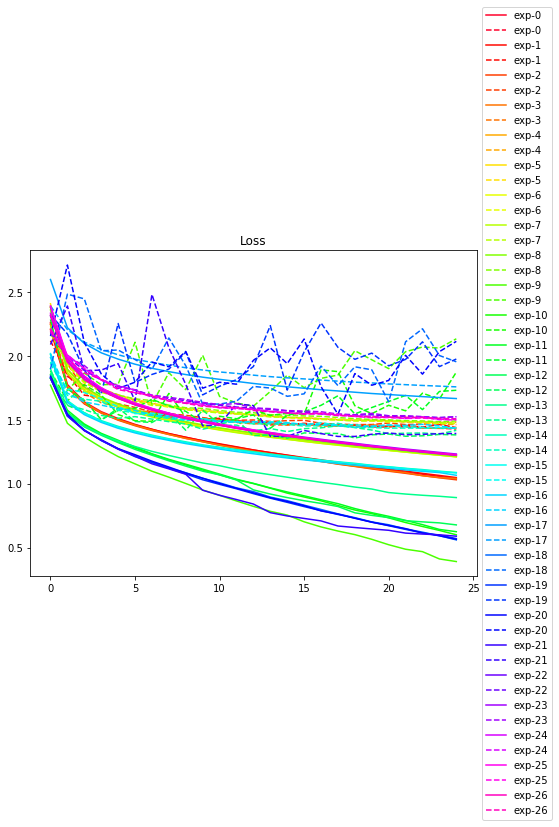

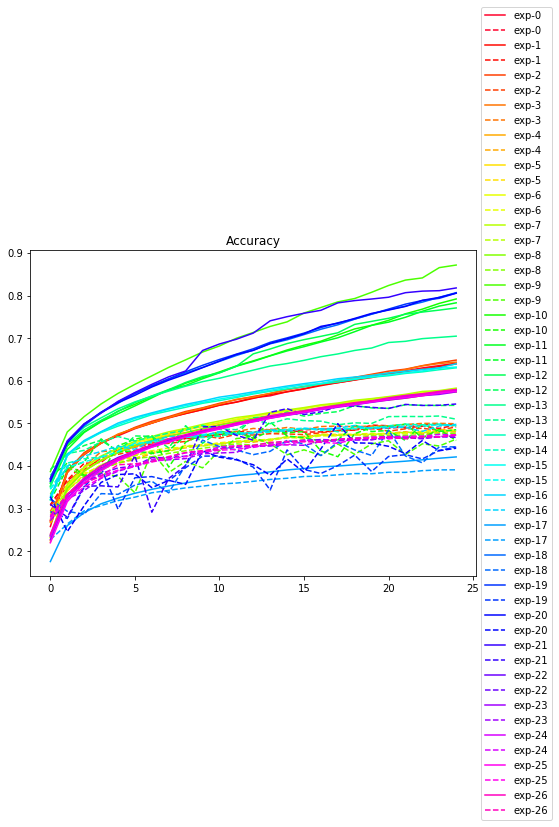

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()